# Explain

I will use Shap to explain original and adversarial images all across this project. In order to do the explanation using shap we need to run tensorflow in lazy execution mode which was the default for Tensorflow 1.0 but is not in 2.0 anymore. Disabling Eager Execution needs to run on python runtime startup and cannot be changed afterwards. I.E. that SHAP explanations need to run in its own jupyter notebook.

In [1]:
import shap
import tensorflow as tf
from keras.models import load_model
from numpy import argmax
from pandas import concat, DataFrame

from data.file import model_convolutional_dataset, shap_original_label
from data.file import shap_original, shap_original_missmatches
from data.load import load_test_dataset
from reporting.evaluation import plot_shap, first_occurence, random_sample
from reporting.images import display_dataframe

In [2]:
print("SHAP version is      :", shap.__version__)
print("Tensorflow version is:", tf.__version__)

tf.compat.v1.disable_eager_execution()

SHAP version is      : 0.40.0
Tensorflow version is: 2.6.2


## Load Data, Predictions
Again I am doing 10000 predictions (basically the whole test dataset) and store actual and predicted label into comparison dataframe. The missmatches are also selected for further SHAP analysis.

In [3]:
x_test, y_test = load_test_dataset(normalize=True)
model = load_model(model_convolutional_dataset)

In [4]:
compare_items = 10000
prediction = [argmax(x) for x in model.predict(x_test[:compare_items])]
expectation = y_test[:compare_items]

comparison = concat([expectation.rename('actual'), DataFrame(prediction, columns=['prediction'])], axis=1)
comparison_missmatch = comparison[comparison.prediction != comparison.actual]

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [5]:
comparison_missmatch = comparison.iloc[comparison_missmatch.index]
labels = comparison_missmatch.prediction.map(str) + " (" + comparison_missmatch.actual.map(str) + ")"

In [6]:
missmatches = x_test[comparison_missmatch.index]

### Display missmatches
Out of 10'000 predictions (amount of test images) we should get roughly between 100 and 200 misspredicted images. This assumption is made out of the recall we got during [model evaluation](./01_confusion_matrix.ipynb). The following table shows all misspredicted items to get an idea of how good the model works (even as human it is sometimes hard to make a prediction).

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


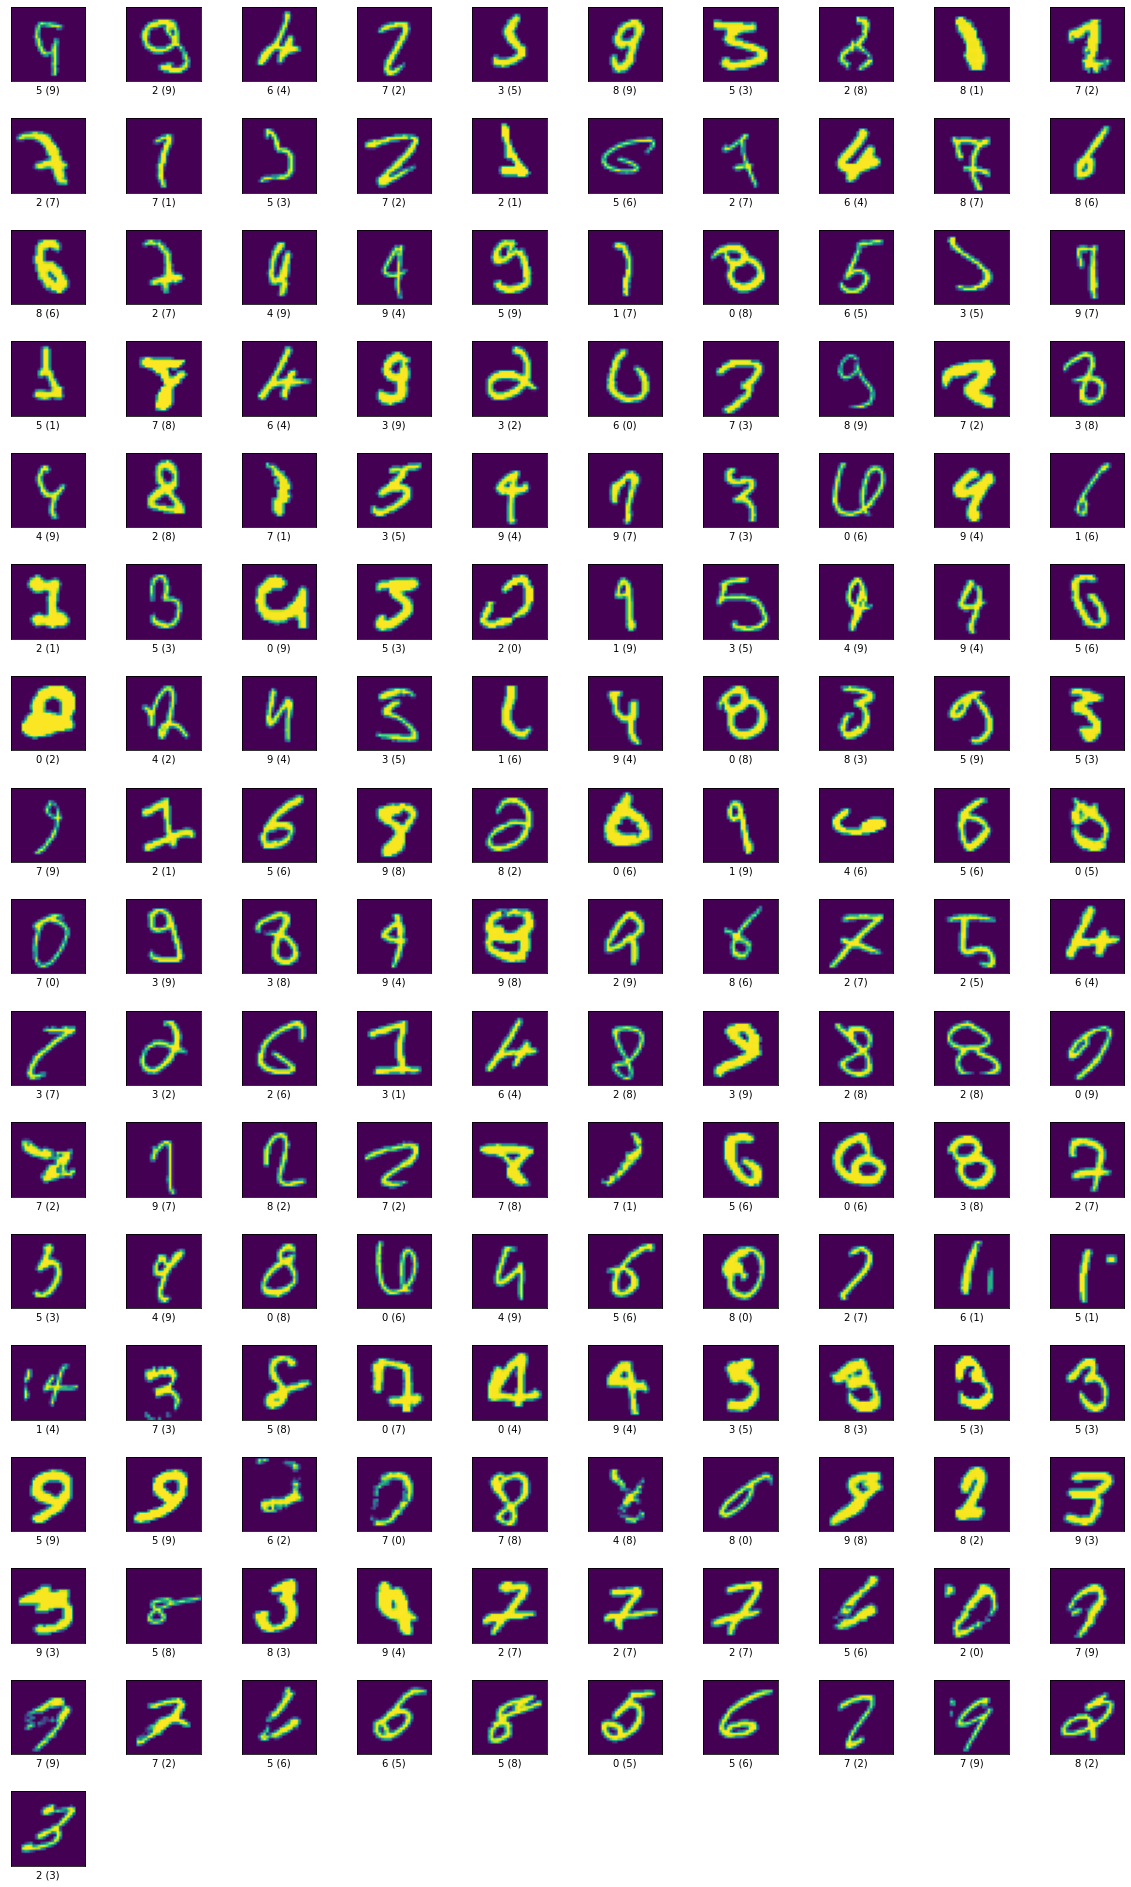

In [8]:
display_dataframe(missmatches, labels=labels.tolist(), cols=10)

## SHAP
I decided to use SHAP to analyze first valid, then invalid predictions. The reason for using SHAP was that I was expecting highly interpretable explanations and performance did not really matter in my case. The first analysis is made based on originals out of the MNIST dataset - first with a focus on valid predictions, then on misspredictions. The [second SHAP analysis](./04_explain_shap_adversarial_images.ipynb) will be made based on [Adversarial Images](./03_adversarial_images_generation_fgsm.ipynb) again for valid and invalid predictions.

*The function plot_shap is using [shap library](https://shap-lrjball.readthedocs.io) and its [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) under the hood. It is an enhanced version of DeepLIFT where similar to Kernel SHAP, the conditional expectations of SHAP values is approximated based on a selection of background samples.*

### Analyze Valid Predictions
The following plot show SHAP explanation for images that were successfully predicted. It is an explanation of randomly selected digits [0-9] out of test dataset.

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


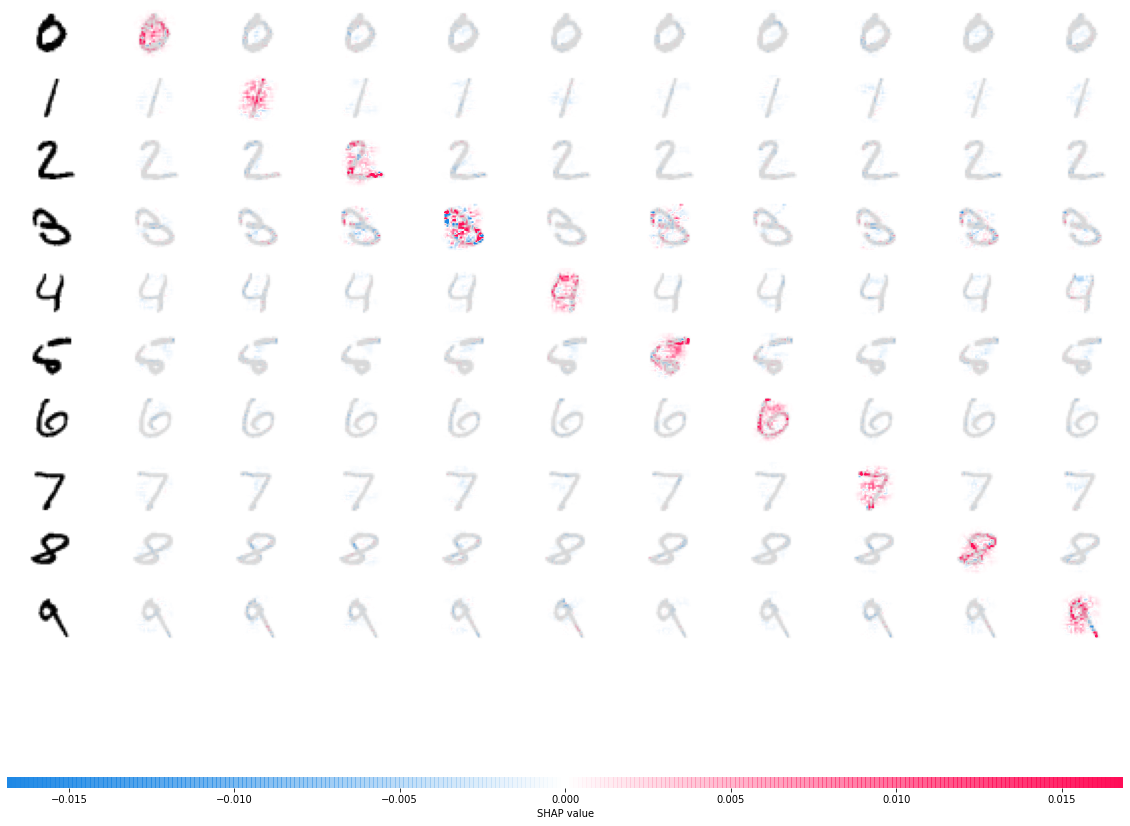

In [14]:
plot_shap(model, x_test[first_occurence(y_test)], background=random_sample(x_test, 4000), file=shap_original)

Input images are displayed on the left, and the interpretation for every class (digits 0-9) on the right.

**Note: I am addressing rows, columns with index starting at 1.**

While color red is indicating strong positive relevance / support for a given number, color blue is similarly indicating strong negative relevance. This indicators (red/blue color) are shown on black and white background - however it looks like the model learnd to primarily focus on the dark pixels.

**Note: For a perfectly working model I would expect a rather red diagonale (for all the valid predictions)**

#### Explanation per digit
| Digit | Explanation                                                                                                                                                                  |
|-------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 0     | The empty center of the digit 0 gives a strong positive relevance. There is no real support across other digits.                                                             |
| 1     | White space on left, right side as well as the vertical center line gives a strong relevance for digit 1.                                                                    |
| 2     | The line as well as the empty space right to the center is supporting digit 2 positively.                                                                                    |
| 3     | There is a positive relevance in the center. We see that the upper circle closes too much (indicated by the blue points). Classifying this digit seems to be harder overall. |
| 4     | Strong relevance because of blank top center, white space bottom left. We see that this blank middel at the top is giving negative relevance for a 9.                        |
| 5     | Farly positive because of the blank space middle right.                                                                                                                      |
| 6     | Seems to be the only digit with a vertical line bottom left. The model seems to be fairly confident.                                                                         |
| 7     | The model is fairly confident that it is a 7, however it looks like it is missing the middle horizontal line.                                                                |
| 8     | Two closed circles are classified as an 8. The bottom circle seems to be too small.                                                                                          |
| 9     | Top circle and long vertical line on the right are classified as a 9                                                                                                         |

### Analyze Misspredictions
I am even more interested how a shap plot of misspredicted digits might look like. Therefore out of the misspredictions I take every first digit and print a shap plot.

In [10]:
first_missmatch_ids = first_occurence(y_test[comparison_missmatch.index])
missmatches_in_plot = comparison.iloc[first_missmatch_ids]
missmatches_in_plot.to_parquet(shap_original_label)
missmatches_in_plot

,actual,prediction
1621,0,6
619,1,8
321,2,7
449,3,5
247,4,6
340,5,3
1014,6,5
684,7,2
582,8,2
62,9,5


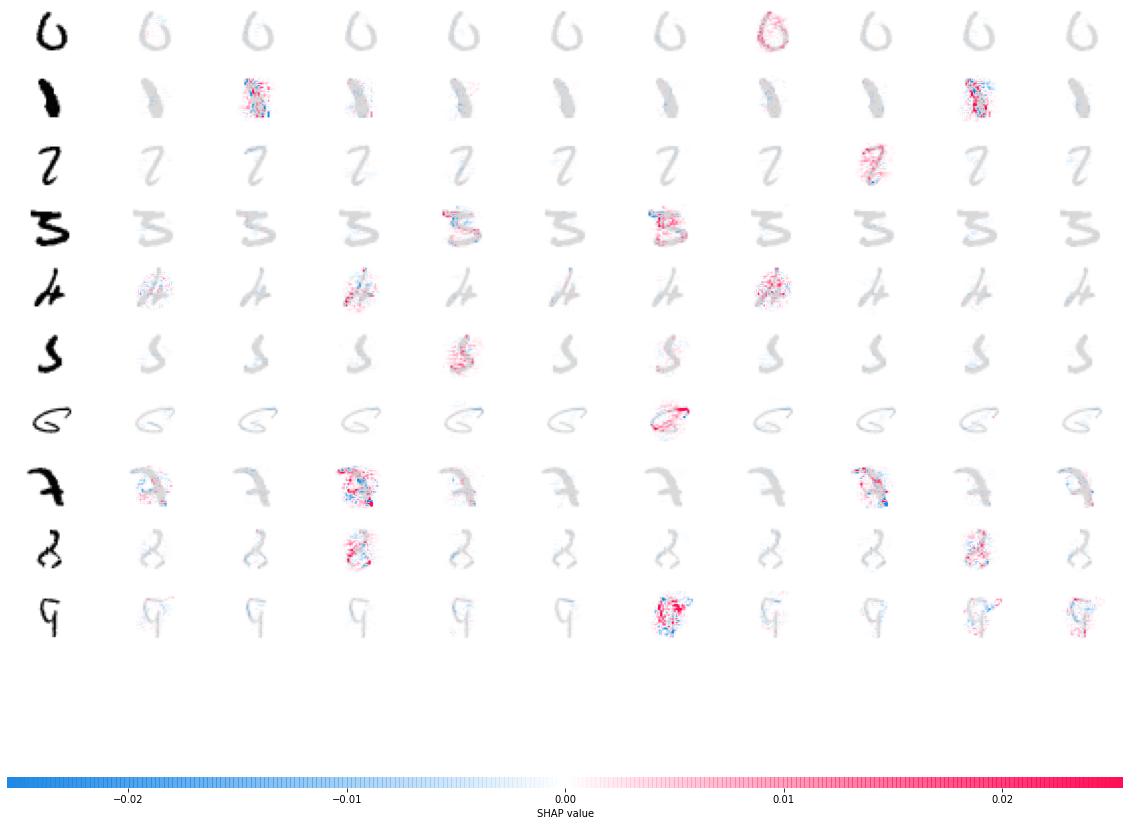

In [15]:
plot_shap(model, x_test[first_missmatch_ids], background=random_sample(x_test, 4000), file=shap_original_missmatches)

#### Explanation per digit
| Digit | Prediction | Explanation |
|-------|------------|-------------|
| 0     |            |             |
| 1     |            |             |
| 2     |            |             |
| 3     |            |             |
| 4     |            |             |
| 5     |            |             |
| 6     |            |             |
| 7     |            |             |
| 8     |            |             |
| 9     |            |             |